# Introducution

* Hello, my name is Shorter
* This is my project detailing the process undertaken to predict home values using 2017 Zillow home information

## Project Objective 
> Document code, process data (through entire pipeline), and articulate key findings and takeways in a jupyter notebook final report 
* Create modules that faciliate project repeatability, as well as final report readability
> Ask/Answer exploratory questions of data and attributes to understand drivers of home value  
* Utilize charts and statistical tests
> Construct models to predict logerror for single family properties using regression techniques
> Make recommendations

## Project Business Goals
> Construct ML Regression model that accurately predicts Log Error (Log Error = Log(Zestimate) - Log(SalePrice)) of *Single Family Properties* using attributes of the properties? </br>
> Find key drivers of log error</br>
> Deliver report that the data science team can read through and replicate, while understanding what steps were taken, why and what the outcome was.
> Make recommendations on what works or doesn't work in predicting LogError

### Executive Summary
* Large numbers of homes in LA County fit the profile for lower value homes:
    - Smaller, older, less rooms, and higher taxes
* Need much more robust feature set for modeling

# Import Section

In [1]:
#### Import Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import wrangle_zillow
import explore_zillow

from itertools import product
from scipy.stats import levene , pearsonr, spearmanr, mannwhitneyu, f_oneway, ttest_ind
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE, f_regression, SelectKBest

import warnings
warnings.filterwarnings("ignore")


> - ## Acquire
> - If no matching csv found, sql query a custom search, returning a dataframe that is then cleaned (dropping columns and replacing NaNs with 0 where applicable), feature engineered (clusters and domain knowledge), split (56%,24%,20%) with those scaled (MinMax)

In [2]:
#calling prepare/acquire functions from module to acruire data subsets
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_zillow()


(28971, 22) (12417, 22) (10348, 22)
-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51736 entries, 1727539 to 1187175
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   basementsqft                51736 non-null  float64 
 1   bathrooms                   51736 non-null  float64 
 2   bedrooms                    51736 non-null  float64 
 3   area                        51736 non-null  float64 
 4   county                      51736 non-null  object  
 5   garagecarcnt                51736 non-null  float64 
 6   garagetotalsqft             51736 non-null  float64 
 7   latitude                    51736 non-null  float64 
 8   longitude                   51736 non-null  float64 
 9   lotsizesquarefeet           51736 non-null  float64 
 10  poolcnt                     51736 non-null  float64 
 11  structuretaxvaluedollarcnt  51736 non-null  float64 
 12  home_va

## Exploration Questions with plots and tests

### Initial Guidance

function to return heatmap to help direct initial questions

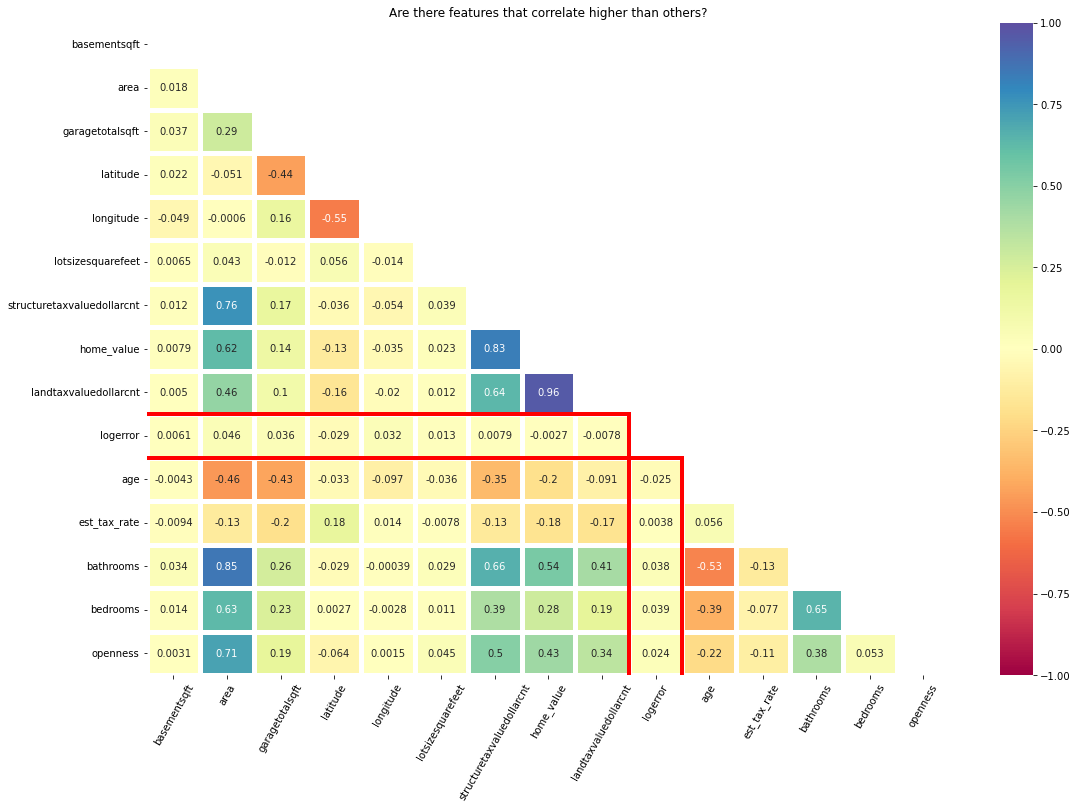

In [3]:
explore_zillow.explore_inital_guidance(train)

No strong relationships are sticking out, Area being the strongest candidate

> ### Question 1 -  Does logerror and Area(sqft) have a signifcant relationship
> ${H_0}$: There is not a significant relationship in LogError and Area 
> ${H_a}$: There is a significant relationship in LogError and Area   
> ${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

Results of SpearmanR (r = 0.081|p = 0.0


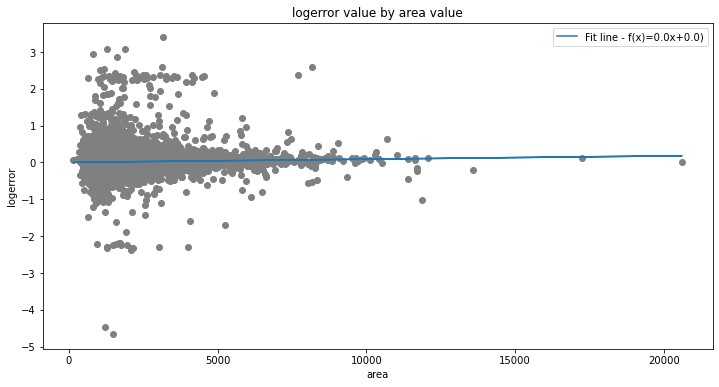

In [4]:
## assigns two variables to be used in the scatterplot, which has a polyline(1) plotted over it,
## Also runs a SpearmanR correlation test and returns the values
col1,target = "area", "logerror"
plt.figure(figsize=(12, 6))
x,y = train[col1], train[target]
r, p = spearmanr(x,y)
plt.plot(x, y, "o",color="grey")
m,b = np.polyfit(x,y,1)
print(f"Results of SpearmanR (r = {round(r,3)}|p = {round(p,3)}")
plt.plot(x,m*x+b,label=f"Fit line - f(x)={round(m,3)}x+{round(b,0)})")
plt.xlabel(col1), plt.ylabel(target)
plt.legend(), plt.title(f"{target} value by {col1} value")
plt.show()

> - #### Q1 takeway:
> - Due to having a p value less than our alpha we were able to determine that there is a relationshiop that we can utilize in our modeling

### Question 2 - Is there a difference in the the sample of no Heating for Log Error?
${H_0}$: There is no significant difference in mean LogError of the sample No Heating compared to the population  
${H_a}$: There is significant difference in mean LogError of the sample No Heating compared to the population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

function from module runs a tailored ttest and plots the feature for this question

In [5]:
df.heating.value_counts()

Central       20407
None          18302
Floor/Wall    12438
Other           589
Name: heating, dtype: int64

In [6]:
train.heating.value_counts()

Central       11444
None          10197
Floor/Wall     7021
Other           309
Name: heating, dtype: int64


 We reject the null Hypothesis ( N̶o̶n̶e̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶h̶e̶a̶t̶i̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=4.02012, p=0.00006


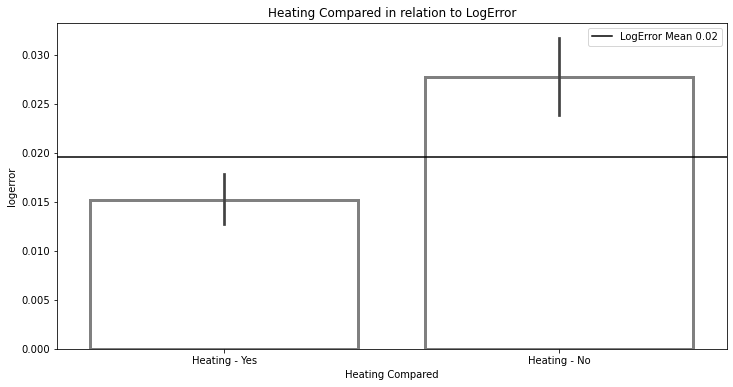

In [7]:
## function in module does a 1 sample TTest against the population and 
## returns the result for Heating(None), plots the feature as sampled
explore_zillow.explore_heating(train)

> - #### Q2 takeway:
> - Whether you have heating or not; does significantly affect LogError, and as such should be considered in Modeling for prediction

### Guidance - Clusters
Run statistical tests on the clusters to verify if the results of our clustering are signifcant

In [8]:
## function in module does a 1 sample TTest against the population for each cluster
## returns the result
explore_zillow.score_clusters(train,"logerror")[["variable","p_val"]].sort_values(by=["p_val"]).head(5)

,variable,p_val
13,cluster house_sizing(1),4.473734e-09
2,cluster house_tax(3),5.027319e-07
14,cluster house_locale(2),6.470090e-07
15,cluster house_locale(3),2.622301e-06
8,cluster house_details(2),7.431146e-05


We have p values low enough to indicate that there may be relationships to investigate

### Question 3 -  Does the Cluster group of Home Size have any clusters that are significantly different in relation to logerror?
${H_0}$: There is no significant difference in mean LogError of the sample Home Size (Cluster 4) compared to the population  
${H_a}$: There is significant difference in mean LogError of the sample Home Size (Cluster 4) compared to the population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

function runs a tailored ttest and plots the feature for this question


 We fail to reject the null hypothesis ( 4 as a sample has equal average values to cluster house_sizing as a population regarding logerror ) t=1.64017, p=0.10101


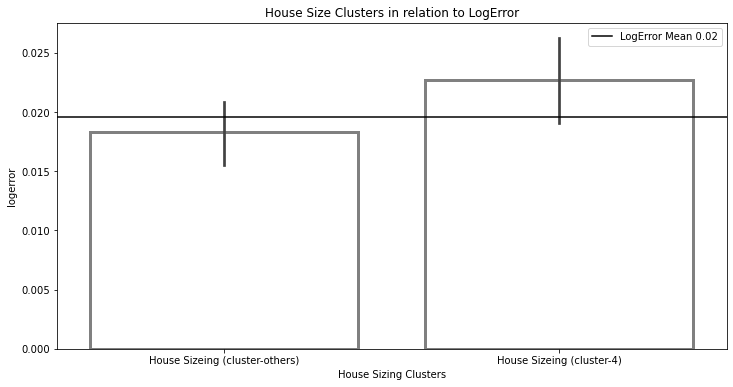

In [9]:
## function tailored for this question. does a sample ttest and returns results with a plot of the feature
explore_zillow.explore_house_size_clusters(train)

> - #### Q3 takeway:
> - The amount of area(sqft), bedrooms, and bathrooms play a role in the ability to predict logerror, with our Cluster 4 being divergent compared to the population

### Question 4 -  Does the Cluster group of House Locale have any clusters that are significantly different in relation to logerror?
${H_0}$: There is no significant difference in mean LogError of the sample House Locale (Cluster 1) compared to the population  
${H_a}$: There is significant difference in mean LogError of the sample House Locale (Cluster 1) compared to the population  
${\alpha}$: .05

> Result: There is enough evidence to reject our null hypothesis. **Test code below**

function runs a tailored ttest and plots the feature


 We reject the null Hypothesis ( 1̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶h̶o̶u̶s̶e̶_̶l̶o̶c̶a̶l̶e̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶l̶o̶g̶e̶r̶r̶o̶r̶ ) t=2.11528, p=0.03443


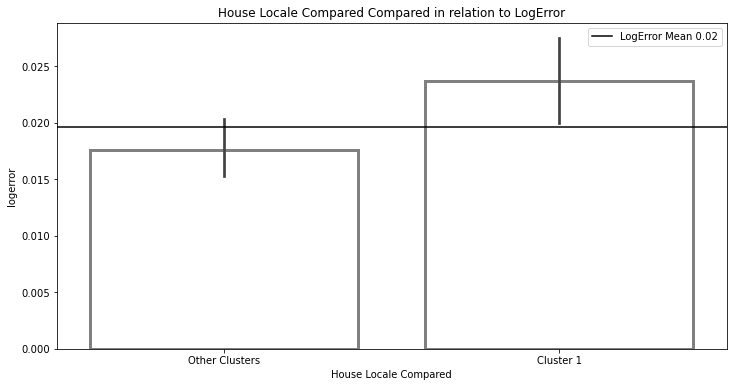

In [10]:
## function tailored for this question. does a sample ttest and returns results with a plot of the feature
explore_zillow.explore_house_locale_cluster(train)

> - #### Q4 takeway:
> - The amount of location (lat and long), and age play a role in the ability to predict logerror, with our Cluster 1 being divergent compared to the population

> - ## Exploration Takeaways
> - A combination of features and clusters will likely give us the best result to predict log error
> - These features may include: Area, Heating, Cluster of Home Size -Area(sqft), Bedroom, Bathroom, Location, and age will all prove to have a level of significance in helping predict our target variable of log error in our modeling

# Modeling

In [11]:
#call modeling preparation function to acquire train/validate/test subsets
X_train, y_train, X_val, y_val, X_test, y_test = modeling_prep(train, train_scaled, validate, validate_scaled, test, test_scaled)

NameError: name 'modeling_prep' is not defined

In [ ]:
#model and score various functions and find list of best three performing
top_three = train_score(X_train, y_train).sort_values(by='r^2 score', ascending=False).head(3)

In [ ]:
top_three

,RMSE,r^2 score,Features,Parameters
Name,,,,
Polynomial_2,174798.934506,0.55,"[bedrooms, bathrooms, area, home_age, est_tax_...",Degree: 3
Polynomial_12,180705.049991,0.51,"[est_tax_rate, area, bathrooms, home_age, coun...",Degree: 3
Polynomial_10,181140.596244,0.51,"[est_tax_rate, area, home_age, county_Orange C...",Degree: 3


## Three Best Models ran on Validation Set
* Polynomials 2 
    - Degrees: 3
    - Features: All
* Polynomial 12
    - Degrees: 3
    - Fetures: estimated tax rate, area, home age, and county
* Polynomial 10
    - Degrees: 3
    - Features: estimated tax rate, area, bathrooms, home age, and county


In [ ]:
#create lists of features
all_features = list(X_train.columns)

feat_set3 = ['est_tax_rate', 'area', 'home_age', 'county_Orange County', 'county_Ventura County']

feat_set4 = ['est_tax_rate', 'area', 'bathrooms', 'home_age', 'county_Orange County', 'county_Ventura County']

#select features and degree level for model testing on validation set
val_selectors = [(all_features, 3), (feat_set3, 3), (feat_set4, 3)]

#call pf function to get predictions for the Polynomial models and add to the dataframe
print(pf_mod(X_val, y_val, val_selectors, X_train, y_train))

#create dataframe to hold model scores
validate_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_val.drop(columns='home_value').columns):
    score = explained_variance_score(y_val['home_value'], y_val[model])
    validate_scores.loc[idx] = [model, score]

           Name                 RMSE  \
0  Polynomial_1  58279225909394752.0   
0  Polynomial_2        182327.056692   
0  Polynomial_3        182006.080466   

                                            Features Parameters  
0  [bedrooms, bathrooms, area, home_age, est_tax_...  Degree: 3  
0  [est_tax_rate, area, home_age, county_Orange C...  Degree: 3  
0  [est_tax_rate, area, bathrooms, home_age, coun...  Degree: 3  


In [ ]:
validate_scores['r^2 Score'] = validate_scores['r^2 Score'].astype('float64')

In [ ]:
for idx in validate_scores.index:
     if validate_scores.loc[idx, 'Model'] == 'Polynomial_1':
          validate_scores.loc[idx, 'Model'] = 'Polynomial_2'
     elif validate_scores.loc[idx, 'Model'] == 'Polynomial_2':
          validate_scores.loc[idx, 'Model'] = 'Polynomial_12'
     elif validate_scores.loc[idx, 'Model'] == 'Polynomial_3':
          validate_scores.loc[idx, 'Model'] = 'Polynomial_10'

In [ ]:

round(validate_scores, 2)


,Model,r^2 Score
0,pred_median,0.000000e+00
1,Polynomial_2,-4.966612e+22
2,Polynomial_12,5.100000e-01
3,Polynomial_10,5.200000e-01


## Test
* Polynomial 10
    - Degrees: 3
    - Features: estimated tax rate, area, bathrooms, home age, and county

 ### Model Code       
        pf_descriptions = pd.DataFrame({}, columns=['Name','RMSE', 'Features', 'Parameters'])

        for idx, combo in enumerate(selectors):
            pf = PolynomialFeatures(degree=combo[1])

            lm = LinearRegression(normalize=True)

            if fit_train is not None:
                fit_pf = pf.fit_transform(fit_train[combo[0]])
                X_pf = pf.transform(X[combo[0]])  
                lm.fit(fit_pf, fit_y_train.home_value)
            else:
                X_pf = pf.fit_transform(X[combo[0]])
                lm.fit(X_pf, y.home_value)

            model_label = f'Polynomial_{idx+1}'

            #predict train
            y[model_label] = lm.predict(X_pf) 

            #calculate train rmse
            rmse = mean_squared_error(y.home_value, y[model_label], squared=False)

            # print(f'{model_label} with degree: {combo[1]} \n\
            #     Features: {combo[0]} \n\
            #     RMSE: {rmse}\n')
            
            description = pd.DataFrame([[model_label, rmse, combo[0], f'Degree: {combo[1]}']], columns=['Name', 'RMSE', 'Features', 'Parameters'])
            pf_descriptions = pd.concat([pf_descriptions, description])

        return pf_descriptions

In [ ]:
#select features and degree level for model testing on test set
test_selectors = [(feat_set4, 3)]

#run function to use model to on test set
pf_mod(X_test, y_test, test_selectors, X_train, y_train)

,Name,RMSE,Features,Parameters
0,Polynomial_1,454892.9766,"[est_tax_rate, area, bathrooms, home_age, coun...",Degree: 3


In [ ]:
#create dataframe to hold model scores
test_scores = pd.DataFrame({}, columns=['Model', 'r^2 Score'])

for idx, model in enumerate(y_test.drop(columns='home_value').columns):
    score = explained_variance_score(y_test['home_value'], y_test[model])
    test_scores.loc[idx] = [model, score]

test_score = explained_variance_score(y_test['home_value'], y_test[model])


In [ ]:
test_score

-782631831999.6567

# Conclusion

## Summary of Key Findings
* Bedrooms, bathrooms, home_size/area and lower age support higher home values
* Large numbers of homes in LA County 
* Estimated Tax rate has negative correlation with home value

## Suggestions and Next Steps
* No suggestions this time as the model does not beat baseline predictions
* Take a look at adding distance relationships
    - Distance from: water, schools, parks, etc. 
* Explore garages and other add-on data such as pools
    - Be willing to impute more data
* Investigate walk/bike/transit scores
* May consider creating county specific models
* Take steps to correct or add null/missing data from properties

In [ ]:
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow.wrangle_zillow()

AttributeError: 'DataFrame' object has no attribute 'area'